# Gaussian Process for Bayesian Optimization

This notebook provides a simple example of how bayes rule is used to find the most likely function representing our unknown true function from scratch using numpy and matplotlib's pyplot function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's assume we have an unknown function, $f(x)$ in the domain $-2 \le x \le 4$ and that the only information we can get is to ask this 'black box' function what the ouptut will be for a given input set we provide: (i.e. we know inputs and outputs only)

<img src="Black Box Function.png">


We want to know what input will provide us with a maximum output. How can we find out? One way to determine our function is to ask what the output will be for every single point in the domain


Note: for the example, the true function is $f(x)=sin(x)$

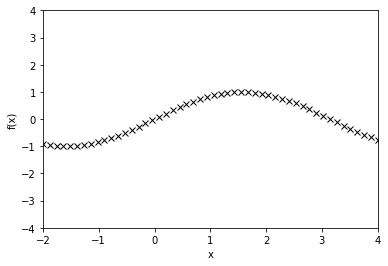

In [2]:
x=np.linspace(-2,4,50)
y=[np.sin(i) for i in x]

plt.plot(x,y,"kx")
plt.xlim([-2,4])
plt.ylim([-4,4])
plt.ylabel("f(x)")
plt.xlabel("x")
plt.show()

But what if we can't do that? Maybe it takes a very long time for the black box to get back to us with an answer or maybe it's very expensive for the black box to evaluate. What should we do?

One method is bayesian optimization:

We treat $f(x)$ as a random function and place a prior distribution, which captures our beliefs about $f(x)$'s behavior, known as a Gaussian Process over it. We then ask for a few input sets to be evaluated and update our prior distribution to incorporate the new information we've gained. This updated distribution is called the posterior distribution:

<img src="Bayes rule with GPs.png">


## Step 1: Create the Prior

### Gaussian Processes

Recall that in statistics, a probability distribution is essentially an equation, or function, which links the possible outcomes of a random phenomenon with its probability of occurrence. An important and often-encountered member of these distributions is referred to as a Gaussian Distribution, which is most known for its characteristic, symmetric 'bell shape'. These distributions are very useful for any analytical manipulations required in statistics because many of the integrals involving Gaussians tend to have simple, closed forms. Set over a finite, k-dimensional space, Gaussians are described by a $k×1$ scalar mean vector and $k×k$ covariance matrix:
$x \sim \mathcal{N}(\mu,\Sigma)$

The infinite-dimensional extension of this distribution is referred to as a Gaussian Process (GP) and represents a distribution over functions. Formally, $p(f)$ is a GP if, for any finite-dimension $k$ subset of its random variables, the joint distribution $f_{x_1,..,x_k}$ produces a Gaussian Distribution.

It may help to consider a single function $f(x)$ drawn from one of these GPs as an infinitely-long vector drawn from an extremely high-dimensional Gaussian. In application, having a GP described in the same manner as a Gaussian Distribution, by an infinite-dimensional scalar mean vector ($\infty ×1$) and infinite-squared covariance matrix ($\infty × \infty $), would be impractical. A GP over an infinite collection of random variables, is, instead, described with a mean function $m$ and a covariance function $k$ 

$f\left(y\right) \sim \mathcal{GP}(m(x),k(x,{x}^{\prime }))$

where

$m(x) = E[x]$

$k(x,x^\prime) = E[(x-m(x))(x^\prime - m(x^\prime))]$


The mean function can be represented as any function; however, the covariance function must result in a positive semi-definite matrix for any of its subset Gaussian Distributions. A positive semi-definite requirement for covariance matrices is identical to Mercer's conditions for kernels; therefore, any kernel-based function is a valid covariance function.

For our unknown function example, the prior information we know includes:
    
1. The function is very smooth (i.e. it is not going to go from 0 to 100 in 1 step)
2. The function evaluations are most likely to be between between -6 and 6

Point 1 is reflected in the type of our covariance or kernel function, which specifies the spatial relationship between two input sets $x$ and $x^\prime$; that is, it acts as an information source detailing the degree at which a change in the distribution value at $x$ will correlate with a change in the distribution value at $x^\prime$. 

The Squared Exponential Kernel, also known as a Gaussian Kernel or Radial Basis Kernel, is one of the most commonly used and smoothest kernels with the following form:
$k_{SE}(x,x^\prime)= \exp{\left[-\sigma^2 \frac{1}{2}{\left(\frac{x-{x}^{\prime}}{\lambda }\right)}^{2}\right]}$

In [3]:
#Squared Exponential Kernel
def SEkernel(x1,x2,hyparams):
    ## hyparams=[sigma,lengthscale]- the hyperparamters of the distribution
#Squared Exponential Kernel for points of x
    return (hyparams[0]**2)*np.exp(-0.5*(x1-x2)**2/(hyparams[1]**2))

Point 2 is reflected in the 'hyperparameter' settings of the kernel.  A squared exponential kernel has 2 hyperparameters: the deviation $\Sigma$ and the lengthscale $\lambda$. We will assume $\lambda=1$ since we don't have any prior knowledge about it; however, remember from probability theory that, for a normal distribution, 95% of the y values will be within $\mu +/- 2\sigma$. Therefore, if  we believe the most probable output is $-6 \le f(x) \le 6$, then we believe the mean $\mu$ is 0 and the standard deviation $\sigma$ is 3.

$k_{SE}(x,x^\prime)= \exp{\left[-\frac{9}{2}{\left(x-{x}^{\prime}\right)}^{2}\right]}$


Given our prior, Let's see what 5 most probable representations of our function $f(x)$ might look like:

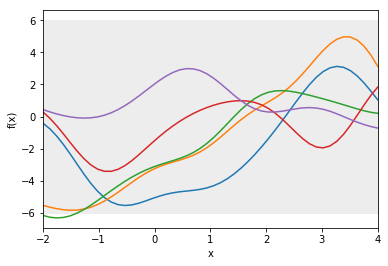

In [4]:
#Generate 5 examples of GP prior

#GP prior
x=np.linspace(-2,4,50)
k=SEkernel(x,x[:,None],[3,1])
mean=np.array(0)

#graph them
z_star=np.random.normal(size=(len(x),5))
#since it is a covariance matrix, use cholesky's LL'= covariance matrix to find the sqrt of the matrix
L=np.linalg.cholesky(k+.000000001*np.eye(len(x)))
f=mean.reshape(-1,1)+np.dot(L,z_star)
stdev=np.sqrt(k.diagonal())
plt.plot(x,f)
plt.xlim([-2,4])
plt.ylabel("f(x)")
plt.xlabel("x")
plt.fill_between(x, mean-2*stdev,mean+2*stdev,color="#ededed")
plt.show()

Since we will be graphing several more times, let's make this graphing code a function for simplicity

In [5]:
#display a graph of possible functions with 2stds
def GraphGaussian(x,mu,sigma,numf):
    #numf: number of example functions to plot
    z_star=np.random.normal(size=(len(x),numf))
    #since it is a covariance, must convert to LL'=sigma
    L=np.linalg.cholesky(sigma+.000000001*np.eye(len(x)))
    f=mu.reshape(-1,1)+np.dot(L,z_star)
    stdev=np.sqrt(sigma.diagonal())
    plt.plot(x,f)
    plt.xlim([-2,4])
    plt.ylabel("f(x)")
    plt.xlabel("x")
    plt.fill_between(x, mu-2*stdev,mu+2*stdev,color="#ededed")
    plt.show()
    return z_star,f,stdev

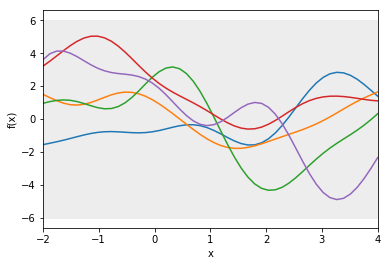

In [6]:
#Run again to check our function works by generating 5 more examples of GP prior
#note: we are randomly generating equally probable examples of functions from our prior so
#      each time we call this, we'll see different functions graphed
x_star=np.linspace(-2,4,50)
k_2star=SEkernel(x_star,x_star[:,None],[3,1])
m_star=np.array(0)
[z_star,f_prior,stdev_prior]=GraphGaussian(x_star,m_star,k_2star,5)

## Step 2: Sample

Now that we have a prior distribution, we need to provide it with some data so it can adjust itself to be more like the actual function. Let's ask our function to evaluate at $x=-1$.

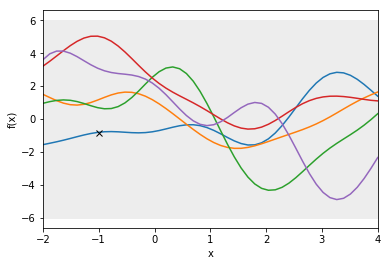

In [7]:
x_ev = np.array([-1])
#true y function  = sin(x)
y_ev=[np.sin(i) for i in x_ev]


#plotting without using our function because we want to show the sample as an 'x' too
plt.plot(x_star,f_prior)
plt.plot(x_ev,y_ev,"kx")
plt.xlim([-2,4])
plt.ylabel("f(x)")
plt.xlabel("x")
plt.fill_between(x_star, m_star-2*stdev_prior, m_star+2*stdev_prior, color="#ededed")
plt.show()

## Step 3: Update our Prior with our Samples

Now that we have data, we need to use baye's rule to update our prior with the new information, which results in a posterior.

=====================================
### Quick Probability Review
Recall from probability, if you have two Gaussian Distributions $x_1 and x_2$ of the form:

$p\left(x_1\right)\sim N(\mu_1, \Sigma_{11})$
	
$p\left(x_2\right)\sim N(\mu_2, \Sigma_{22})$
    
Then their joint distribution results in a Guassian with the following parameters:

$p\left(\left[\begin{array}{c}x_1\\ x_2\end{array}\right]\right) \sim N\left(\mu = \left[\begin{array}{c}{\mu }_{1}\\ {\mu }_{2}\end{array}\right],\Sigma =\left[\begin{array}{cc}{\Sigma }_{11} \ {\Sigma }_{12}\\ {\Sigma }_{21}\ {\Sigma }_{22}\end{array}\right]\right)$

and the conditional densities for each subset is also Gaussian:
	
$p\left(x_1|x_2\right) \sim N(\mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(x_2- \mu_2), \Sigma_{11}-\Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21})$
	
$p\left(x_2|x_1\right) \sim N(\mu_2+ \Sigma_{21}\Sigma_{11}^{-1}(x_1- \mu_1), \Sigma_{22}-\Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12})$

====================================

Our posterior distribution can be considered a joint distribution between what points we have evaluated, which we will designate as $x_{ev},y_{ev}$, and what points we haven't, which we will designate as $x_\star,y_\star$:

$p\left(\left[\begin{array}{c}y_{ev}\\ y_\star\end{array}\right]\right) \sim N\left(\mu = \left[\begin{array}{c}{\mu }_{{ev}}\\ {\mu }_{\star}\end{array}\right],K =\left[\begin{array}{cc}{K}_{ev,ev} \ {K}_{ev,\star}\\ {K}_{\star,ev}\ {K}_{\star,\star}\end{array}\right]\right)$

where $K(\cdot,\cdot)$ is the selected kernel of our prior.

To find our updated function, given the data we've observed so far, $p(y_\star|x_\star,x_{ev},y_{ev})$, we apply the conditional probability reviewed above:

$p\left(y_\star|x_\star,x_{ev},y_{ev}\right) \sim N(\mu_\star+ K_{\star,ev}K_{ev,ev}^{-1}(y_{ev}- \mu_{\star}), K_{\star,\star}-K_{\star,ev} K_{ev,ev}^{-1} K_{ev,star})$

Note: in our cause, our prior says $\mu_{\star}=0$ so we do not include it's subtraction in the following function

In [8]:
#calculate the conditional given data and sample from posterior
def conditional(x_star,x_ev,y_ev,kernel,hyparams):    
    #params are the [sigma, lengthscale] hyperparameters
    #create the pieces of the joint distribution sigma: K**,K,K*
    k_2star = kernel(x_star,x_star[:,None],hyparams)
    k_2ev=kernel(x_ev,x_ev[:,None],hyparams)
    k_ev_star=kernel(x_star,x_ev[:,None],hyparams)
    
    #determine your new mean and covaraince functions using conditional dist
    m_new=np.dot(np.transpose(k_ev_star),np.linalg.inv(k_2ev)).dot(y_ev)
    s_new= k_2star-(np.dot(np.transpose(k_ev_star),np.linalg.inv(k_2ev)).dot(k_ev_star))
    
    return m_new,s_new

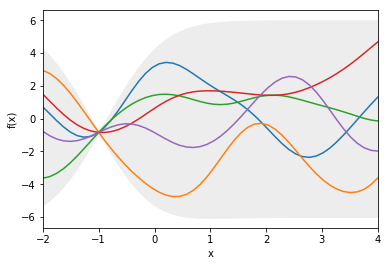

In [9]:
#update our prior with new information
[m_new,s_new]=conditional(x_star,x_ev,y_ev,SEkernel,[3,1])
[z_new,f_post,stdev_post]=GraphGaussian(x_star,m_new,s_new,5)

Notice how the uncertainty around -1 has deminished greatly! Our most likely function to represent our unknown function, $f(x)$ is now restricted to ones which go through or very near (depending on noise assumptions) our evaluated point. Let's sample a few more times.

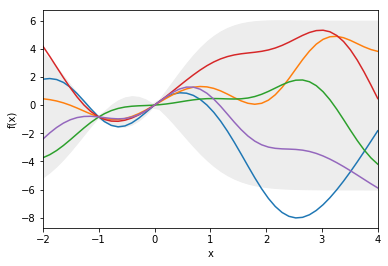

In [10]:
#Let's say we sample again
x_ev=np.append(x_ev,0)
y_ev=[np.sin(i) for i in x_ev]

#update our prior with new information
[m_new,s_new]=conditional(x_star,x_ev,y_ev,SEkernel,[3,1])
[z_new,f_post,stdev_post]=GraphGaussian(x_star,m_new,s_new,5)

In [12]:
#Let's say we sample again
x_ev=np.append(x_ev,4)
y_ev=[np.sin(i) for i in x_ev]

#update our prior with new information
[m_new,s_new]=conditional(x_star,x_ev,y_ev,SEkernel,[3,1])
[z_new,f_post,stdev_post]=GraphGaussian(x_star,m_new,s_new,5)

LinAlgError: Singular matrix

## Final Thoughts

The next question is how do we decide where we should be evaluating? You can see in the last image how evaluating points closer together restricts the probable values at unevaluated points between them more greatly then two that are further apart (the two on the left vs the two on the right). 